# Homework 3

---

## Q1

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*

&nbsp;

## Solution

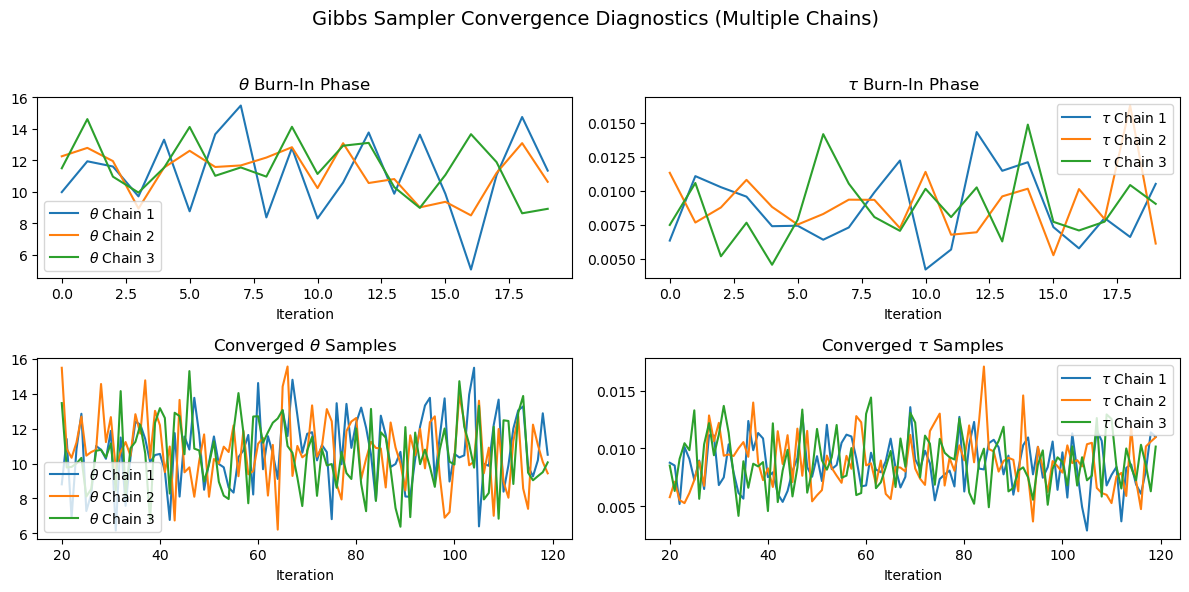

(array([[ 6.8525821 ,  6.82747628,  6.72052934],
        [14.63775386, 14.62515283, 14.62719922]]),
 array([[0.00502484, 0.00498417, 0.00500486],
        [0.0141848 , 0.01417882, 0.01420417]]))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Gibbs sampler for Normal-Gamma model with multiple chains
def gibbs_sampler(n, m, s, C=2, G=10000, burn_in=1000):
    """
    Gibbs sampler for p(theta, tau) ∝ 1 with multiple chains.

    Parameters:
        n (int): Sample size
        m (float): Mean of the normal distribution
        s (float): Standard deviation of the normal distribution
        C (int): Number of chains
        G (int): Number of Gibbs samples per chain
        burn_in (int): Number of burn-in iterations

    Returns:
        theta_samples (ndarray): Posterior samples for θ across chains
        tau_samples (ndarray): Posterior samples for τ across chains
    """
    
    # Generate observed data
    x = stats.norm(loc=m, scale=s).rvs(size=n)
    x_bar = np.mean(x)
    s2 = np.var(x, ddof=1)

    # Initialize storage for multiple chains
    theta = np.zeros((C, G))
    tau = np.zeros((C, G))
    
    # Initialize starting values for each chain
    for c in range(C):
        theta[c, 0] = x_bar + np.random.normal(0, 1)  # Small perturbation
        tau[c, 0] = 1 / s2  # Initial precision estimate

        # Gibbs sampling loop
        for g in range(1, G):
            # Sample theta | tau, x from Normal
            theta[c, g] = stats.norm(loc=x_bar, scale=np.sqrt(1 / (n * tau[c, g - 1]))).rvs()

            # Sample tau | theta, x from Gamma
            alpha_post = n / 2
            beta_post = 0.5 * np.sum((x - theta[c, g])**2)
            tau[c, g] = stats.gamma(a=alpha_post, scale=1 / beta_post).rvs()

    return theta[:, burn_in:], tau[:, burn_in:]

# Parameters
n, m, s = 30, 10, 10# Sample size, mean, standard deviation
C = 3  # Number of chains

# Run Gibbs sampler with multiple chains
theta_samples, tau_samples = gibbs_sampler(n, m, s, C=C)

# Compute posterior credible intervals (95%) across chains
theta_CI = np.quantile(theta_samples, [0.025, 0.975], axis=1)
tau_CI = np.quantile(tau_samples, [0.025, 0.975], axis=1)

# Fixing titles and plot formatting
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle("Gibbs Sampler Convergence Diagnostics (Multiple Chains)", fontsize=14)

ax[0, 0].set_title(r"$\theta$ Burn-In Phase")
ax[0, 1].set_title(r"$\tau$ Burn-In Phase")
ax[1, 0].set_title(r"Converged $\theta$ Samples")
ax[1, 1].set_title(r"Converged $\tau$ Samples")

burn = 20  # Short burn-in period for visualization
demo = 120  # Short chain for visualization

for c in range(C):
    ax[0, 0].plot(theta_samples[c, :burn], label=rf"$\theta$ Chain {c+1}")
    ax[0, 1].plot(tau_samples[c, :burn], label=rf"$\tau$ Chain {c+1}")
    ax[1, 0].plot(np.arange(burn, demo, dtype=int), theta_samples[c, burn:demo], label=rf"$\theta$ Chain {c+1}")
    ax[1, 1].plot(np.arange(burn, demo, dtype=int), tau_samples[c, burn:demo], label=rf"$\tau$ Chain {c+1}")

for a in ax.flatten():
    a.legend()
    a.set_xlabel("Iteration")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Display credible intervals for each chain
theta_CI, tau_CI


## Q2

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau^2_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*


&nbsp;

## Solution

Our prior on $\tau$ is $\tau \sim \text{Gamma}(\frac{\alpha}{2}, \frac{\lambda}{2})$.

#### By Bayes' theorem, 
$$ \large
\begin{align}
p(\tau | \theta, \mathbf{x}) &\propto p(\mathbf{x} | \tau, \theta) p(\tau) \\
& = \prod^n_{i=1} \exp \left(-\frac{\tau}{2} (x_i - \theta)^2 \right) \cdot ( -\tau^{\frac{\alpha}{2}-1}e^{-\frac{\lambda}{2}\tau})\\
& \propto \tau^{\frac{n + \alpha}{2} - 1} \exp \left( -\frac{\tau}{2} \sum^n_{i=1} (x_i - \theta)^2 - \frac{\lambda}{2}\tau \right) \\
& = \tau^{\frac{n+\alpha}{2} - 1} \exp\left( -\frac{\tau}{2} ( \sum_{i=1}^{n} (x_i - \theta)^2 + \lambda ) \right)
\end{align}
$$



#### Recognizing this as the kernel of a gamma distribution, we conclude:
$$\large \tau | \theta, \mathbf{x} \sim \text{Gamma} \left( \frac{\alpha}{2} + \frac{n}{2}, \frac{\lambda}{2} + \frac{1}{2} \sum_{i=1}^{n} (x_i - \theta)^2 \right).$$

From this we see that the likelihood contributes $\frac{n}{2}$ observations and half of the sum of squared errors in estimating $\theta$. So correspondingly, $\alpha$ determines how many additional pseudo-data points are introduced by the prior, and $\theta$ determines the strength of the prior’s precision (i.e., how informative these pseudo-data points are). When $\alpha$ is large and $\theta$ is small, the prior assumes high uncertainty, so the data dominates. Conversely, if $\alpha$ is large and $\theta$ is also large, the prior dominates the inference.




#### By Bayes' theorem,

$$
\large \begin{align*}
 p(\theta | \tau, \mathbf{x}) &\propto p(\mathbf{x} | \theta, \tau) p(\theta)\\
    &= \prod_{i=1}^{n} \exp\left(-\frac{\tau}{2} (x_i - \theta)^2 \right) \cdot \exp\left(-\frac{1}{2 \tau_0^2} (\theta - \theta_0)^2 \right) \\
    &\propto \exp\left(-\frac{\tau}{2} \sum_{i=1}^{n} (x_i - \theta)^2 - \frac{1}{2 \tau_0^2} (\theta - \theta_0)^2 \right) \\
    &= \exp\left(-\frac{1}{2} \left( \theta^2 (n\tau + \frac{1}{\tau_0^2}) - 2\theta (n\tau \bar{x} + \frac{\theta_0}{\tau_0^2}) \right) \right)\\
    &= \exp \: \left( -\frac{1}{2} (n\tau + 1/\tau_0^2) \left( \theta - \frac{n\tau \bar{x} + \theta_0 / \tau_0^2}{n\tau + 1/\tau_0^2} \right)^2 \right)
\end{align*}
$$

#### Recognizing this as the kernel of a normal distribution, we conclude:

$$
\large \theta | \tau, \mathbf{x} \sim \mathcal{N} \left( \frac{n\tau \bar{x} + \theta_0 / \tau_0^2}{n\tau + 1/\tau_0^2}, \frac{1}{n\tau + 1/\tau_0^2} \right).
$$


Posterior Summary for α=1, λ=1 (Weak Prior):
  θ: Mean = 4.958, Std = 0.295, 95% CI = [4.38503928 5.53305605]
  τ: Mean = 0.232, Std = 0.046, 95% CI = [0.15056167 0.33019736]
--------------------------------------------------
Posterior Summary for α=10, λ=1 (Strong Prior on τ):
  θ: Mean = 4.961, Std = 0.268, 95% CI = [4.432743   5.48390106]
  τ: Mean = 0.274, Std = 0.050, 95% CI = [0.18438543 0.37739682]
--------------------------------------------------
Posterior Summary for α=1, λ=10 (Strong Prior on Variance):
  θ: Mean = 4.946, Std = 0.305, 95% CI = [4.35506818 5.54837673]
  τ: Mean = 0.222, Std = 0.044, 95% CI = [0.14675221 0.31665375]
--------------------------------------------------
Posterior Summary for α=10, λ=10 (Very Informative Prior):
  θ: Mean = 4.959, Std = 0.280, 95% CI = [4.38735765 5.49743506]
  τ: Mean = 0.263, Std = 0.048, 95% CI = [0.17415253 0.36830661]
--------------------------------------------------


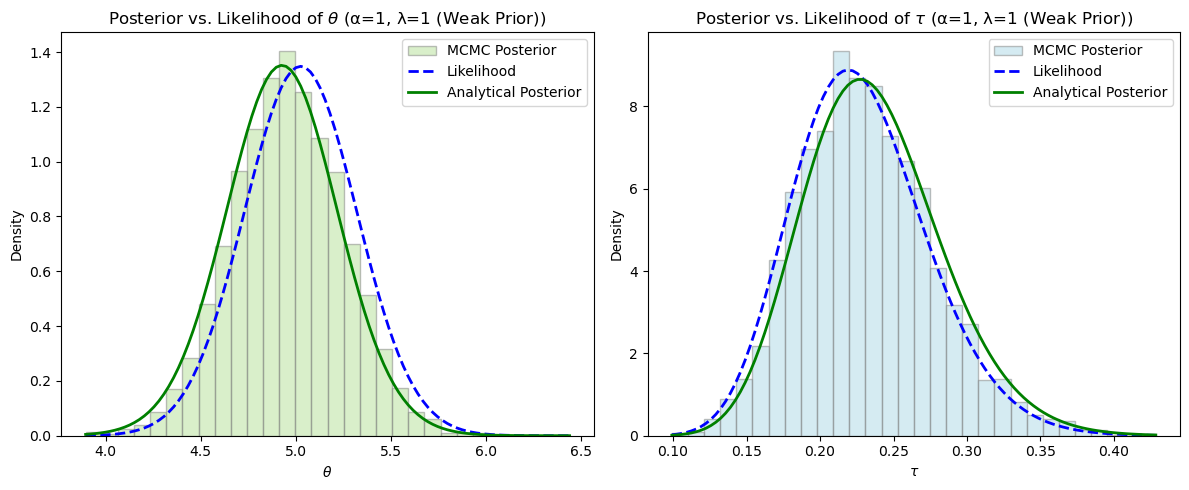

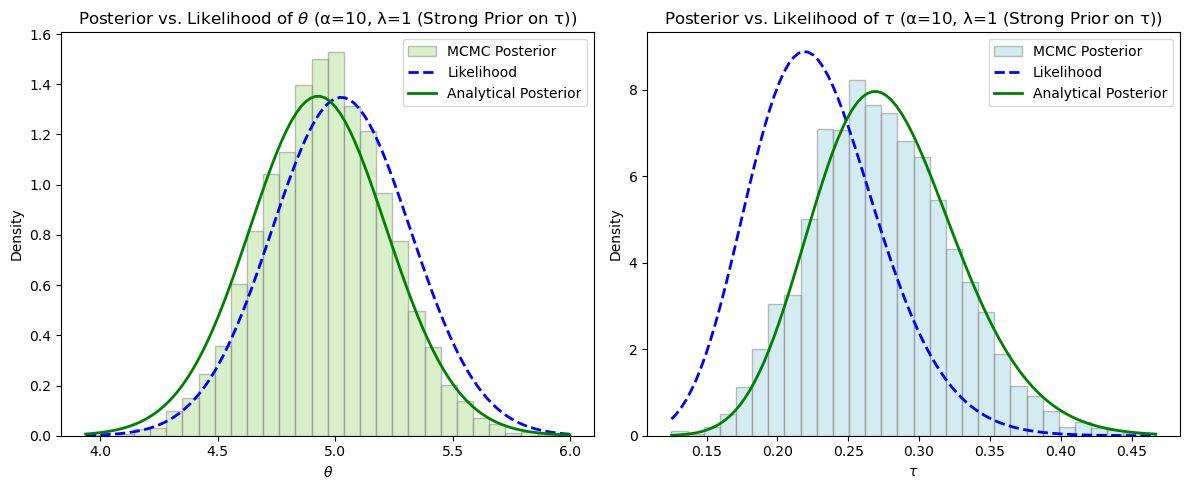

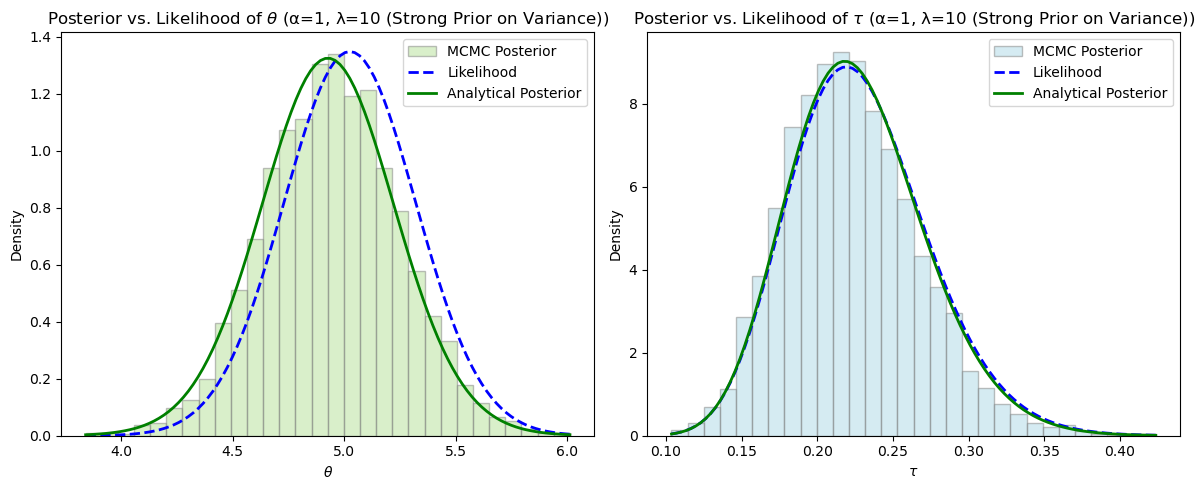

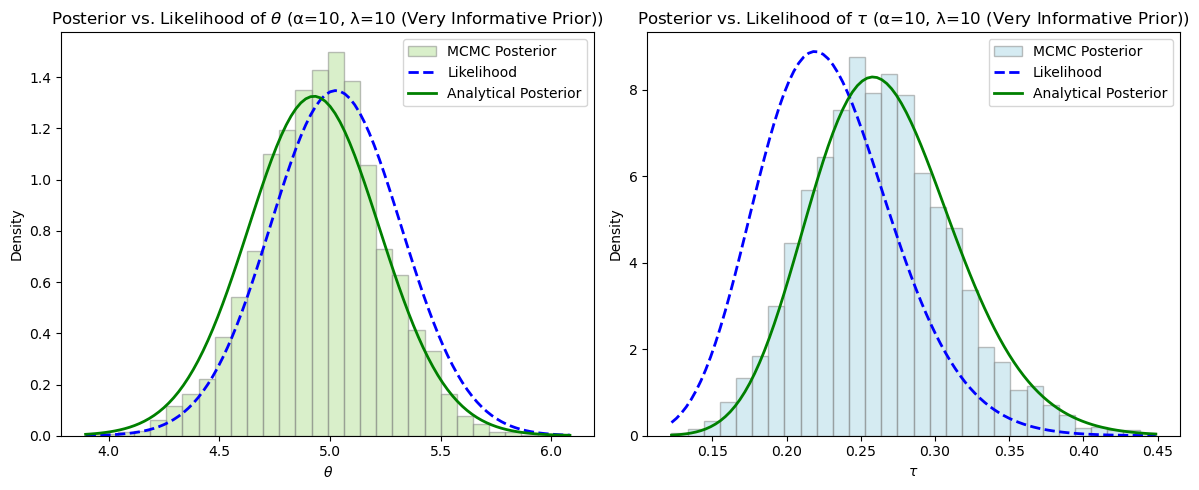

In [11]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def gibbs_sampler_normal_gamma(n_iter, x, theta_0, tau_0_sq, alpha, lambda_):
    """
    Gibbs sampler for Bayesian inference using Normal-Gamma prior.
    
    Parameters:
    - n_iter: Number of iterations
    - x: Data samples
    - theta_0: Prior mean for theta
    - tau_0_sq: Prior variance for theta
    - alpha: Shape parameter for gamma prior on precision
    - lambda_: Rate parameter for gamma prior on precision
    """
    n = len(x)
    x_bar = np.mean(x)

    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    tau = np.random.gamma(alpha / 2, 2 / lambda_)

    for i in range(n_iter):
        # Sample theta from normal full conditional
        var_theta = 1 / (n * tau + 1 / tau_0_sq)
        mean_theta = var_theta * (n * tau * x_bar + theta_0 / tau_0_sq)
        theta = np.random.normal(mean_theta, np.sqrt(var_theta))

        # Sample tau from gamma full conditional
        alpha_post = alpha / 2 + n / 2
        lambda_post = lambda_ / 2 + 0.5 * np.sum((x - theta) ** 2)
        tau = np.random.gamma(alpha_post, 1 / lambda_post)

        # Store samples
        theta_samples[i] = theta
        tau_samples[i] = tau

    return theta_samples, tau_samples


n_samples = 50
true_mean = 5
true_std = 2
data_samples = stats.norm(loc=true_mean, scale=true_std).rvs(size=n_samples)


hyperparam_sets = [
    {"alpha": 1, "lambda": 1, "label": "α=1, λ=1 (Weak Prior)"},
    {"alpha": 10, "lambda": 1, "label": "α=10, λ=1 (Strong Prior on τ)"},
    {"alpha": 1, "lambda": 10, "label": "α=1, λ=10 (Strong Prior on Variance)"},
    {"alpha": 10, "lambda": 10, "label": "α=10, λ=10 (Very Informative Prior)"},
]


n_iter = 5000

theta_0 = 0       # Prior mean for theta
tau_0_sq = 6      # Prior variance for theta

posterior_results = {}
for params in hyperparam_sets:
    alpha, lambda_ = params["alpha"], params["lambda"]
    theta_samples, tau_samples = gibbs_sampler_normal_gamma(
        n_iter, data_samples, theta_0, tau_0_sq, alpha, lambda_
    )
    posterior_results[params["label"]] = (theta_samples, tau_samples)
    
for label, (theta_samples, tau_samples) in posterior_results.items():
    theta_mean, theta_std = np.mean(theta_samples), np.std(theta_samples)
    tau_mean, tau_std = np.mean(tau_samples), np.std(tau_samples)
    theta_ci = np.percentile(theta_samples, [2.5, 97.5])
    tau_ci = np.percentile(tau_samples, [2.5, 97.5])
    
    print(rf"Posterior Summary for {label}:")
    print(f"  θ: Mean = {theta_mean:.3f}, Std = {theta_std:.3f}, 95% CI = {theta_ci}")
    print(f"  τ: Mean = {tau_mean:.3f}, Std = {tau_std:.3f}, 95% CI = {tau_ci}")
    print("-" * 50)



def plot_likelihood_posterior(theta_samples, tau_samples, data, params, label):

    n = len(data)
    x_bar = np.mean(data)
    s_sq = np.var(data, ddof=1)

    alpha, lambda_ = params["alpha"], params["lambda"]

    # Analytical posterior parameters
    tau_posterior_shape = (alpha / 2) + (n / 2)
    tau_posterior_scale = 2 / (lambda_ + np.sum((data - x_bar) ** 2))

    theta_posterior_mean = (n * x_bar / s_sq + params.get("theta_0", 0) / params.get("tau_0_sq", 1)) / (n / s_sq + 1 / params.get("tau_0_sq", 1))
    theta_posterior_var = 1 / (n / s_sq + 1 / params.get("tau_0_sq", 1))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot θ posterior with likelihood overlay
    theta_x = np.linspace(min(theta_samples), max(theta_samples), 100)
    likelihood_pdf = stats.norm(loc=x_bar, scale=np.sqrt(s_sq / n)).pdf(theta_x)
    
    # Posterior for θ
    nu_theta = alpha + n  # Degrees of freedom
    mu_theta = (n * x_bar + params.get("theta_0", 0) / params.get("tau_0_sq", 1)) / (n + 1 / params.get("tau_0_sq", 1))
    sigma_theta = np.sqrt((1 / (n + 1 / params.get("tau_0_sq", 1))) * (np.var(data, ddof=1) + lambda_ / n))

    posterior_pdf_theta = stats.t(df=nu_theta, loc=mu_theta, scale=sigma_theta).pdf(theta_x)


    axes[0].hist(theta_samples, bins=30, density=True, alpha=0.5, color='#B4E197', edgecolor='grey', label="MCMC Posterior")
    axes[0].plot(theta_x, likelihood_pdf, 'b--', linewidth=2, label="Likelihood")
    axes[0].plot(theta_x, posterior_pdf_theta, 'g-', linewidth=2, label="Analytical Posterior")
    axes[0].set_title(rf"Posterior vs. Likelihood of $\theta$ ({label})")
    axes[0].set_xlabel(r"$\theta$")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    # Plot τ posterior with likelihood overlay
    tau_x = np.linspace(min(tau_samples), max(tau_samples), 100)
    likelihood_pdf_tau = stats.gamma(a=n / 2, scale=2 / (n * s_sq)).pdf(tau_x)
    posterior_pdf_tau = stats.gamma(a=tau_posterior_shape, scale=tau_posterior_scale).pdf(tau_x)

    axes[1].hist(tau_samples, bins=30, density=True, alpha=0.5, color='#ADD8E6', edgecolor='grey', label="MCMC Posterior")
    axes[1].plot(tau_x, likelihood_pdf_tau, 'b--', linewidth=2, label="Likelihood")
    axes[1].plot(tau_x, posterior_pdf_tau, 'g-', linewidth=2, label="Analytical Posterior")
    axes[1].set_title(rf"Posterior vs. Likelihood of $\tau$ ({label})")
    axes[1].set_xlabel(r"$\tau$")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Run for each prior setting
for params in hyperparam_sets:
    label = params["label"]
    theta_samples, tau_samples = posterior_results[label]
    plot_likelihood_posterior(theta_samples, tau_samples, data_samples, params, label)


## Q3

*Read the following "conversation". My reactions to this initial text I was provied with are the colored font. Then either (A) provide an analagous derivation of this result for the multinomial-Dirichlet specification, or (B) just report that if the prior is a proper distribution then the posterior is proportional to the joint distribution as Bayes Theorem tells us and describe how one might therefore identify the exact distribution of the posterior by just looking at the joint but that finally all this is moot and beside the point because as Bayesians we're going to trade any functional forms of distributions for samples from those distributions to just make histograms and belief (credible interval probability) statements based on those anyway...*

Suppose we have the following model setup:
\begin{align*}
    x_1,...,x_n &\overset{iid}{\sim} \text{Bernoulli}(\theta)\\
    \theta &\sim \text{Beta}(a, b)
\end{align*}

The joint likelihood distribution of ~~x_1,...,x_n~~ <span style='color:red'> $\sum_i x_i$</span> $| \theta$ is $\text{Binomial}(n, \theta)$. Now, let's consider the posterior:
\begin{align*}
    p(\theta | x_1,...,x_n) &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{p(x_1,...,x_n)} = \color{red}{\frac{p(\mathbf{x} | \theta)p(\theta)}{p(\mathbf{x})}}\\
    &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\int p(x_1,...,x_n | \theta )p(\theta) d\theta} = \color{red}{\frac{p(\mathbf{x}| \theta)p(\theta)}{\int p(\mathbf{x} | \theta )p(\theta) d\theta}}
\end{align*}

We can directly calculate the above if the denominator is finite. We tend to use proportionality arguments in this class, but to build some intuition <span style='color:red'>Bayes theorem is $p(\theta | \mathbf{x}) = \frac{p(\mathbf{x} | \theta )p(\theta)}{p(x)}$ and (if we know $\mathbf{x}$) then $p(\mathbf{x})$ is a constant so we must gather all $\theta$ related terms in our mathematical expression (dropping anything else which is any other constant) and see if we know of any statistical distribution that when scaled by a constant could exactly replicate our math as a function of $\theta$</span>, <span style='color:blue'>but if by "intuition" you mean the next 10 lines of derivation because you refuse to believe that the posterior is proportional to the joint (for proper priors) as Bayes Theorem claims</span> let's formally calculate that integral for the Beta-Binomial problem:

$\scriptsize
\begin{align*}
    \int p(\overset{\color{red}{\textrm{You meant } \sum_i x_i}}{x_1,...,x_n} | \theta )p(\theta) d\theta &= \int_0^1 \color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}} \overset{\color{blue}{\textrm{just this alone is a Bernoulli likelihood}}}{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1}(1-\theta)^{b-1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\int_0^1 \theta^{\sum_i x_i + a - 1}(1-\theta)^{n-\sum_i x_i + b - 1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}\int_0^1 \frac{\Gamma(a+b+n)}{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}\theta^{\sum_i x_i + a - 1}(1-\theta)^{n-\sum_i x_i + b - 1}d\theta \\
    &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}\\& \text{ (because we have written the density formula above, which integrates to } 1)\\    
  & \color{blue}{\textrm{(But why stop there shouldn't we prove the integral is equal to 1 for "intuition"?)}}\\
    & \color{red}{\textrm{(if "intuition" may assume a density has area 1 then prove or believe Bayes Theorem)}}\\
    & \color{purple}{\textrm{Proof: $p(\theta|\mathbf{x})p(\mathbf{x}) = p(\mathbf{x}|\theta)p(\theta) \Rightarrow p(\theta|\mathbf{x}) = \frac{p(\mathbf{x}|\theta)p(\theta)}{p(\mathbf{x})}$}} \\    
    & \color{green}{\textrm{(Bayes Theorem is the formula for a posterior distribution if the prior is proper)}}\\
    & \color{blue}{\textrm{(If you believe it then the posterior is proportional to the joint and must have area 1)}}\\
    & \color{red}{\textrm{(Can you recognize what distribution for $\theta$ would be proportional to the given joint?)}}\\
    & \color{green}{\textrm{(There's only gonna be one... can't be two... can you find one distribution that does it?)}}\\
\end{align*}$

Now, we can directly plug in to our Bayes formula to directly calculate the posterior:

$\begin{align*}
    p(\theta | x_1,...,x_n) &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\int p(x_1,...,x_n | \theta )p(\theta) d\theta} \\
    &= \frac{p(x_1,...,x_n | \theta)p(\theta)}{\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}} \overset{\color{blue}{\textrm{just this alone is a Bernoulli likelihood}}}{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i}} \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\theta^{a-1}(1-\theta)^{b-1}}{\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\color{red}{\overset{\textrm{erroneous}}{\begin{pmatrix}
        n \\ \sum_i x_i
    \end{pmatrix}}}\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\theta^{\sum_i x_i}(1-\theta)^{n-\sum_i x_i} \theta^{a-1}(1-\theta)^{b-1}}{\frac{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}{\Gamma(a+b+n)}} \\
    &= \frac{\Gamma(a+b+n)}{\Gamma(a+ \sum_i x_i)\Gamma(b + n - \sum_i x_i)}\theta^{\sum_i x_i + a-1}(1-\theta)^{n-\sum_i x_i+b-1} \\
    &= \text{Beta}(a+ \sum_i x_i, b + n - \sum_i x_i)
\end{align*}$

<span style='color:blue'>
So the structure of this "proof" providing the right kind of "intution" you'll apparently need to feel comfortable and safe about proportionality (if believing that the posterior is proportional to the joint as Bayes Theorem claims is a step too far for you) is...</span>

$\color{green}{\require{cancel}
\begin{align*}
\frac{p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}} &={} \frac{\cancel{c_xc_\theta} c p(\boldsymbol{\theta}|\textbf{x})}{\cancel{c_xc_\theta} \int c p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}}\\
&={} \frac{c p(\boldsymbol{\theta}|\textbf{x})}{ c \int \xcancel{\frac{1}{c} c} p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}} =  \frac{c p(\boldsymbol{\theta}|\textbf{x})}{ c \cancel{\int p(\boldsymbol{\theta}|\textbf{x})d \boldsymbol{\theta}}^1} = \frac{\xcancel{c} p(\boldsymbol{\theta}|\textbf{x})}{ \xcancel{c} } = p(\boldsymbol{\theta}|\textbf{x})\\
\end{align*}}
$

<span style='color:blue'>
Or here's an even more direct way to show this...
</span>

$\color{red}{
\begin{align*}
\frac{p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\textbf{x}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
 &={} \frac{p(\boldsymbol{\theta}|\textbf{x})p(\textbf{x})}{p(\textbf{x})} \\
  &={} p(\boldsymbol{\theta}|\textbf{x})
\end{align*}}
$    



We can see that when we have ~~**conjugate** priors (where the prior and posterior have the same form)~~ <u>**just any (propor) prior**</u>, the denominator in Bayes rule amounts to any normalizing constants in the likelihood and prior (that allow for the densities to integrate to 1 times the inverse of the equivalent normalizing constant of the posterior. Once we plug this back in to Bayes formula and cancel and rearrange terms, this amounts to multiplying the normalizing constant of the posterior with the portion of the posterior that relies on the parameter. This sort of derivation isn't unique to conjugate priors; as long as we can recognize the family in which the product of the prior and likelihood belong to, the integral in the denominator can be solved by simplifying the term in the integral to the precise density (which occurs by moving normalizing constants outside of the integral, and introducing the normalizing constant for that new density). This is the technique we used to solve the integral above.

As a result, we can use a proportionality argument to skip all of these mathematical derivations. If we can recognize the functional form of the product between the likelihood and prior as being in the family of another probability distribution, then that is equivalent to moving around these normalizing constants to simplify integrals.



&nbsp;

## Solution



**Statement:**  
Given a likelihood function $ p(x | \theta) $ and a proper prior $ p(\theta) $, the prior predictive distribution:

$$
p(x) = \int_{\Theta} p(x | \theta) p(\theta) d\theta
$$

is a proper probability distribution, meaning it integrates to 1.

---

#### **Proof**
To show that $p(x) $ is proper, we need to verify:

$$
\int_{\mathcal{X}^n} p(x) dx = 1.
$$

We proceed as follows:

\begin{align*}
\int_{\mathcal{X}^n} p(x) dx 
&= \int_{\mathcal{X}^n} \int_{\Theta} p(x | \theta) p(\theta) d\theta \, dx\\
&= \int_{\Theta} \int_{\mathcal{X}^n} p(x | \theta) dx \, p(\theta) d\theta  && \text{(Fubini's theorem)} \\
&= \int_{\Theta} 1 \cdot p(\theta) d\theta  \\
&= \int_{\Theta} p(\theta) d\theta. \\
&= 1.  && \text{(Since \( p(\theta) \) is proper)}
\end{align*}

Thus,

$$
\int_{\mathcal{X}^n} p(x) dx = 1.
$$

Since the prior predictive (marginal likelihood) is finite, the posterior:

\begin{align}
p(\theta | x) = \frac{p(x | \theta) p(\theta)}{p(x)}
\end{align}

is well-defined, meaning the **posterior is always proportional to the joint** when the prior is proper.
